# Import modules

In [36]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

# from tqdm import tqdm
# import concurrent.futures

import sys
sys.path.append('../')

from src.config import *
from src.helper_visualization import *
from src.helper_pred import *

# Load Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100402 entries, 0 to 100401
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        100402 non-null  int64 
 1   Title             100402 non-null  object
 2   Product Name      100402 non-null  object
 3   Length            100402 non-null  int64 
 4   Language          100402 non-null  object
 5   Title_Processed   100402 non-null  object
 6   Title_Translated  100402 non-null  object
 7   Title_Enhanced    100402 non-null  object
 8   Tags              100402 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11156 entries, 0 to 11155
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        11156 non-null  int64 
 1   Title             11156 non-null  object
 2   Product Name      111

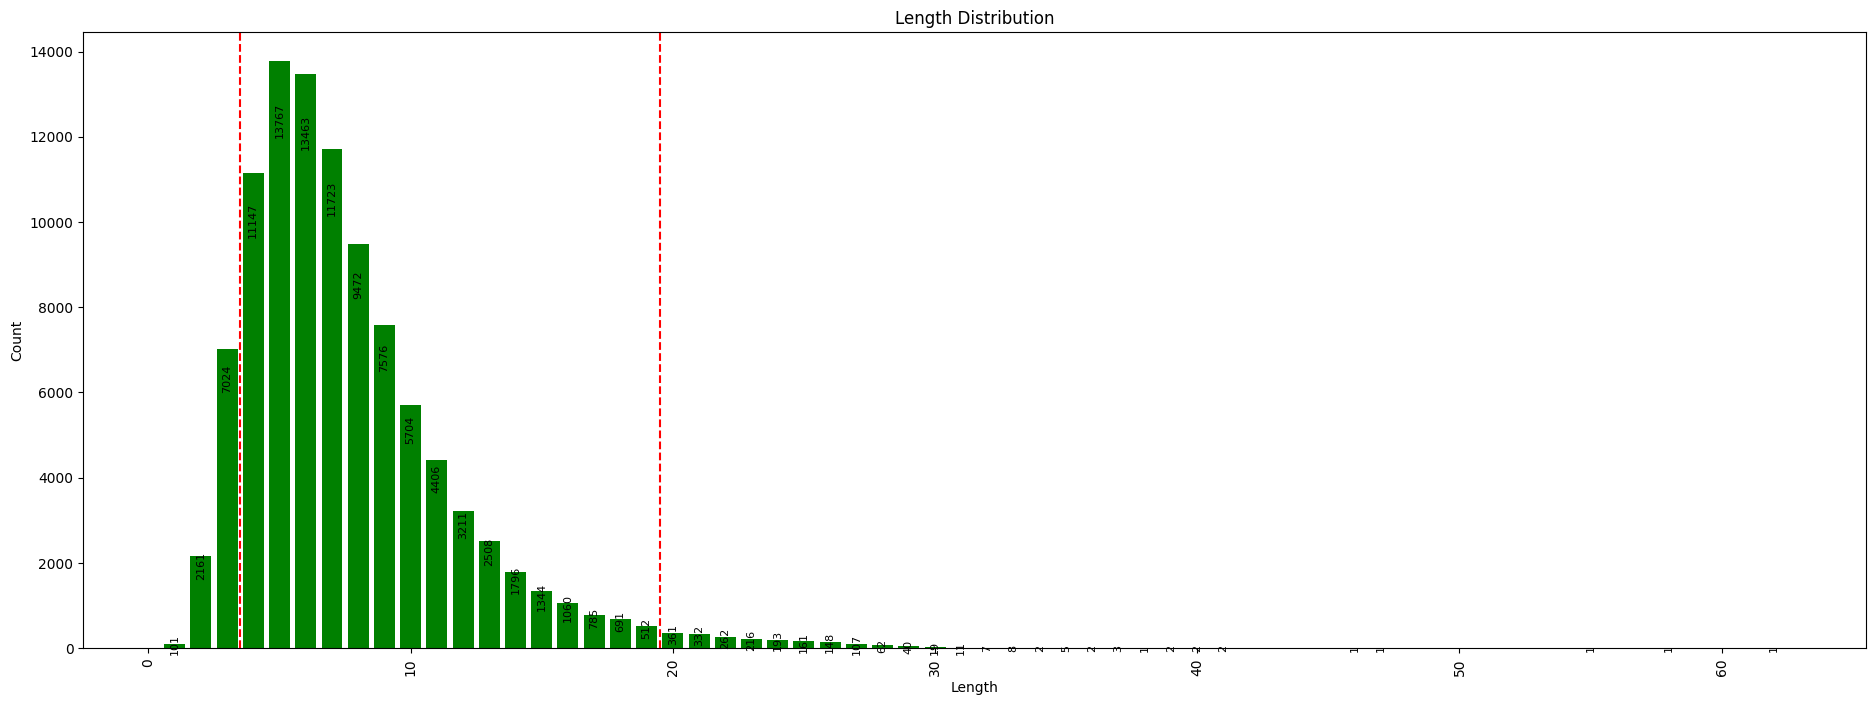

In [37]:
# excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
excel_file_train = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'
df_train = pd.read_excel(excel_file_train)
excel_file_test = f'{DATA_FOLDER_PATH_PROCESSED}/data_test.xlsx'
df_test = pd.read_excel(excel_file_test)

print(df_train.info())
print(df_test.info())
hist_by_labels(df_train, 'Length', log=False, left=TITLE_WORDS_MIN+0.5, right=TITLE_WORDS_MAX-0.5)
# plot a square in red color on the histogram

# Train/Test Datasets

Pipeline Construction

In [38]:
# Define global variables
TITLE_WORDS_MIN = 3
TITLE_WORDS_MAX = 20
LONGTAIL_CUTOFF = 200

TEXT_COL = 'Title_Enhanced'
TARGET_COL = 'Product Name'

PRODUCT_SIZE_MAX_TRAIN = 2000
PRODUCT_SIZE_MAX_TEST = 300
MAX_FEATURES = 20000

from sklearn.base import BaseEstimator, TransformerMixin

# create a scikit-learn transformer to remove the title with less than 3 words or more than 20 words
class TitleLengthFilter(BaseEstimator, TransformerMixin):
    def __init__(self, min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX):
        self.min_words = min_words
        self.max_words = max_words
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = X.copy()
        df = df[df['Length'] >= self.min_words]
        df = df[df['Length'] <= self.max_words]
        df = df.reset_index(drop=True)
        return df

# create a scikit-learn transformer to combine the products which have less than 200 samples into one product
class LongTailCombiner(BaseEstimator, TransformerMixin):
    def __init__(self, min_samples=200, target_col=TARGET_COL):
        self.min_samples = min_samples
        self.target_col = target_col
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = X.copy()
        counts = df[self.target_col].value_counts()
        long_tails = counts.index[counts < self.min_samples]
        mask = df[self.target_col].isin(long_tails)
        df.loc[mask, self.target_col]='Long Tail'
        return df

# create a scikit-learn transformer to cap the number of samples for each product
class SampleCapper(BaseEstimator, TransformerMixin):
    def __init__(self, max_samples=200, target_col=TARGET_COL):
        self.max_samples = max_samples
        self.target_col = target_col
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = X.copy()
        counts = df[self.target_col].value_counts()
        over_sampled = counts.index[counts > self.max_samples]
        # mask = df[self.target_col].isin(over_sampled)
        # df = df.drop(df[mask].sample(frac=1-self.max_samples/len(df)).index)
        for item in over_sampled:
            size = len(df[df[self.target_col]==item])
            df = df.drop(df[df[self.target_col]==item].sample(frac=1-self.max_samples/size).index)
        return df

# create a scikit-learn pipeline to remove the title with less than 3 words or more than 20 words
from sklearn.pipeline import Pipeline

pipleline_data_prep_train = Pipeline([
    ('title_length_filter', TitleLengthFilter(min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX)),
    ('long_tail_product_combiner', LongTailCombiner(min_samples=LONGTAIL_CUTOFF, target_col=TARGET_COL)),
    ('sample_capper', SampleCapper(max_samples=PRODUCT_SIZE_MAX_TRAIN, target_col=TARGET_COL)),
    # ('text_vectorizer', TextVectorizer(vectorizer=vectorizer))
])

pipleline_data_prep_test = Pipeline([
    ('title_length_filter', TitleLengthFilter(min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX)),
    ('long_tail_product_combiner', LongTailCombiner(min_samples=LONGTAIL_CUTOFF*12//100, target_col=TARGET_COL)),
    ('sample_capper', SampleCapper(max_samples=PRODUCT_SIZE_MAX_TEST, target_col=TARGET_COL)),
    # ('text_vectorizer', TextVectorizer(vectorizer=vectorizer))
])
display(pipleline_data_prep_train)
display(pipleline_data_prep_test)

Pipeline(steps=[('title_length_filter', TitleLengthFilter()),
                ('long_tail_product_combiner', LongTailCombiner()),
                ('sample_capper', SampleCapper(max_samples=2000))])

Pipeline(steps=[('title_length_filter', TitleLengthFilter()),
                ('long_tail_product_combiner',
                 LongTailCombiner(min_samples=24)),
                ('sample_capper', SampleCapper(max_samples=300))])

Data Processing

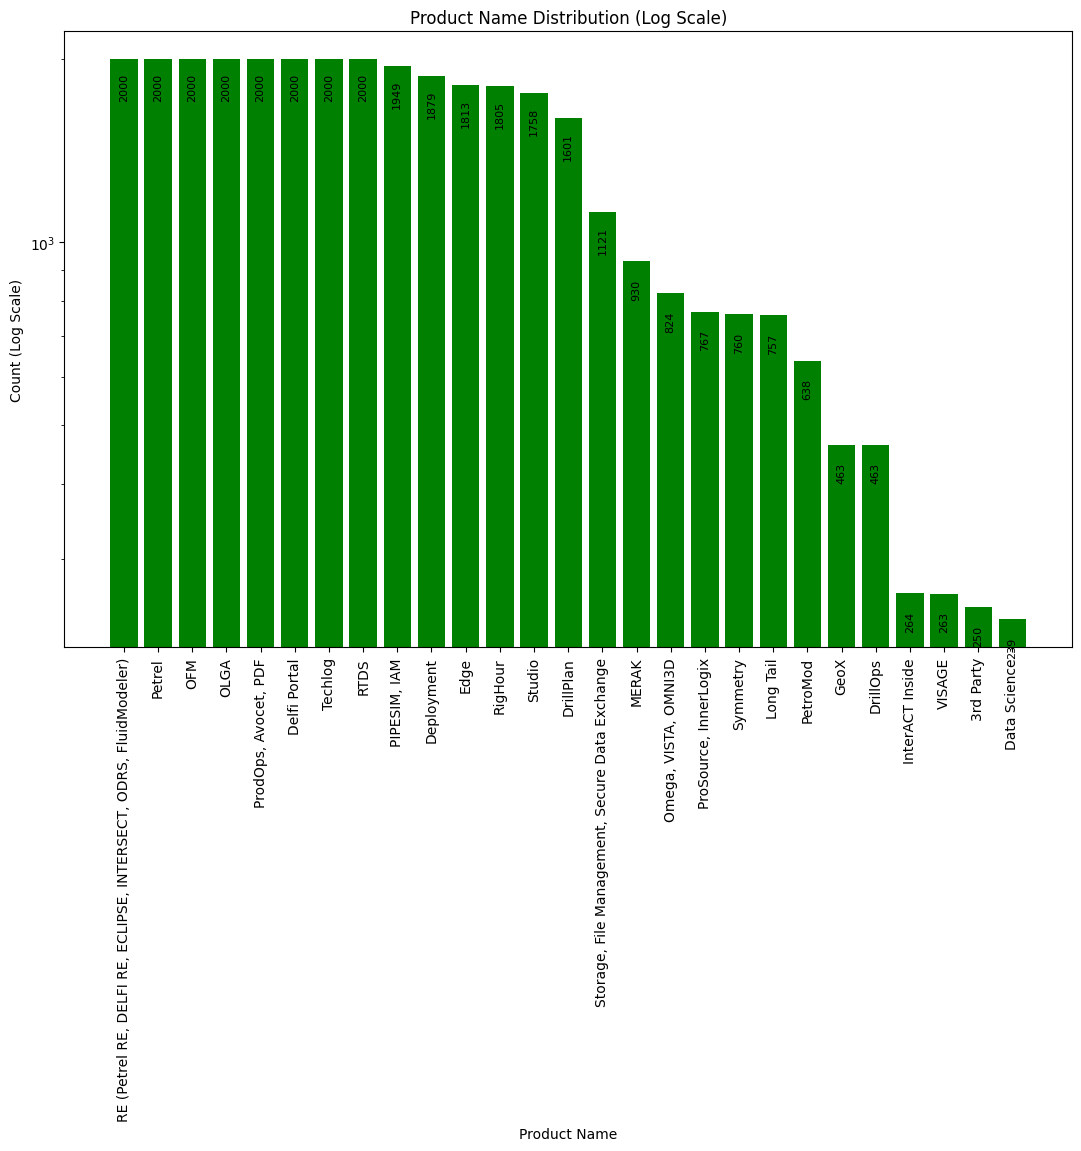

<class 'pandas.core.frame.DataFrame'>
Index: 34544 entries, 7 to 96549
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        34544 non-null  int64 
 1   Title             34544 non-null  object
 2   Product Name      34544 non-null  object
 3   Length            34544 non-null  int64 
 4   Language          34544 non-null  object
 5   Title_Processed   34544 non-null  object
 6   Title_Translated  34544 non-null  object
 7   Title_Enhanced    34544 non-null  object
 8   Tags              34544 non-null  object
dtypes: int64(2), object(7)
memory usage: 2.6+ MB


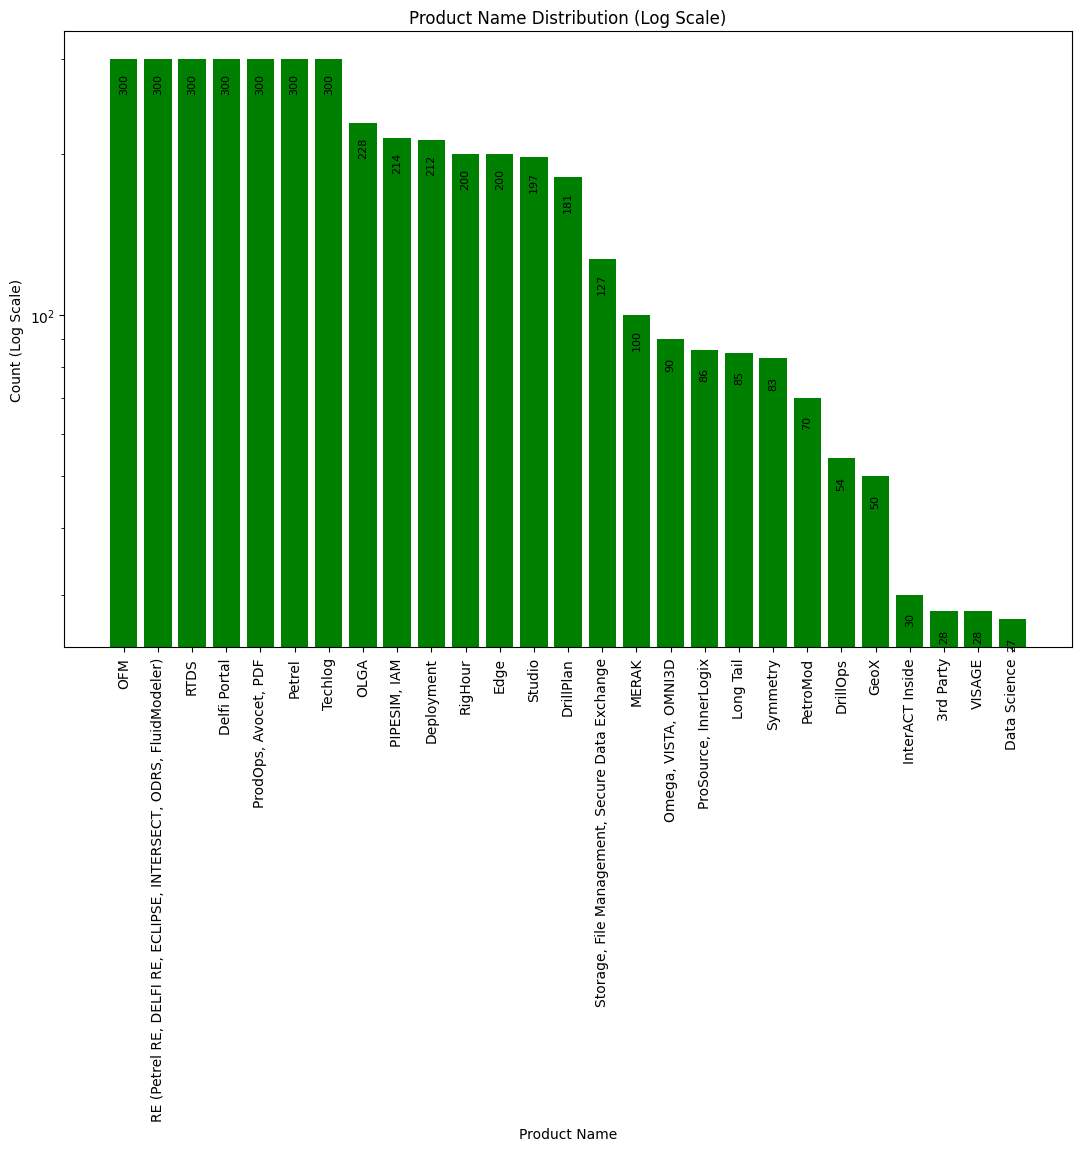

<class 'pandas.core.frame.DataFrame'>
Index: 4390 entries, 1 to 10720
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        4390 non-null   int64 
 1   Title             4390 non-null   object
 2   Product Name      4390 non-null   object
 3   Length            4390 non-null   int64 
 4   Language          4390 non-null   object
 5   Title_Processed   4390 non-null   object
 6   Title_Translated  4390 non-null   object
 7   Title_Enhanced    4390 non-null   object
 8   Tags              4390 non-null   object
dtypes: int64(2), object(7)
memory usage: 343.0+ KB


In [39]:
train_data = pipleline_data_prep_train.fit_transform(df_train)
hist_by_labels(train_data, 'Product Name', log=True, horizontal=True)
train_data.info()

test_data = pipleline_data_prep_test.fit_transform(df_test)
hist_by_labels(test_data, 'Product Name', log=True, horizontal=True)
test_data.info()

# Word2Vec

In [ ]:
from gensim.models import Word2Vec
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import optuna

# Load the pre-trained Word2Vec model
import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')

# train the word2vec_model using additional X_train data
# word2vec_model.build_vocab(X_train, update=True)
word2vec_model.train(X_train, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)

# Define a function to encode the text using Word2Vec
def encode_text(text):
    words = text.split()
    vectors = []
    for word in words:
        if word in word2vec_model:
            vector = word2vec_model[word]
            vectors.append(vector)
    if len(vectors) == 0:
        return np.zeros(dim) # Return a vector of zeros if no words are found
    else:
        return np.mean(vectors, axis=0) # Return the mean of the word vectors

# Vectorize the training and testing data using Word2Vec
X_train_word2vec = [encode_text(text) for text in X_train]
X_test_word2vec = [encode_text(text) for text in X_test]


# Clean up the study if it exists
study_name = 'sgd_classifier_word2vec'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_word2vec, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)


In [ ]:

# Vectorize the training and testing data using Word2Vec
X_train_word2vec = [encode_text(text) for text in X_train]
X_test_word2vec = [encode_text(text) for text in X_test]


# Clean up the study if it exists
study_name = 'sgd_classifier_word2vec'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_word2vec, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)


In [ ]:
import gensim
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Load the pre-trained Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format(f'{MODEL_FOLDER_PATH}/word2vec/GoogleNews-vectors-negative300.bin', binary=True, limit=200000)


In [ ]:
# Load the pre-trained GloVe embeddings
embeddings_index = {}
dim = 300

with open(f'{MODEL_FOLDER_PATH}/glove/glove.6B.{dim}d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Define a function to encode the text using GloVe
def encode_text(text):
    words = text.split()
    vectors = []
    for word in words:
        if word in embeddings_index:
            vector = embeddings_index[word]
            vectors.append(vector)
    if len(vectors) == 0:
        return np.zeros(dim) # Return a vector of zeros if no words are found
    else:
        return np.mean(vectors, axis=0) # Return the mean of the word vectors

# Vectorize the training and testing data using GloVe
X_train_glove = [encode_text(text) for text in X_train]
X_test_glove = [encode_text(text) for text in X_test]

# Tensorflow

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_core as keras
import keras_nlp

print('Tensorflow version:', tf.__version__)
print('KerasNLP version:', keras_nlp.__version__)

In [ ]:
BATCH_SIZE = 32
NUM_TRAIN_SAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = NUM_TRAIN_SAMPLES * TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 3
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
from sklearn.model_selection import train_test_split

X = X_train
y = y_train

# encode the target
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)


In [ ]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"
NUM_CLASSES = len(df_train['Product Name'].unique())

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset, sequence_length=160, name="preprocessor_4_tweets")

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset, preprocessor = preprocessor, num_classes=NUM_CLASSES)

classifier.summary()

In [ ]:
# Compile the model
classifier.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-5),
    metrics=['accuracy'])

# Fit the model.
history = classifier.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val)
    )

In [ ]:
# plot the training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test data
y_pred_tf = classifier.predict(X_test)
y_pred_tf = np.argmax(y_pred_tf, axis=1)

# Decode the predictions
y_pred_tf = label_encoder.inverse_transform(y_pred_tf)

# Evaluate the model on the test data

accuracy = accuracy_score(y_test, y_pred_tf)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_tf, digits=3))

plot_confusion_matrix(y_test, y_pred_tf, title='Confusion matrix')